# Fake News and Real News Classification
**Kan Zhou and Minhui Ma**

## 1. Problem Statement

The problem our group wants to solve is to explore the difference between fake news and real news and to create a classification model to classify fake news from real news. 
Since recently, with the development of digital media, countless news was published on websites; however, it is hard for readers to distinguish the fake news and true news. Therefore, we want to extract some keywords in both true news and fake news. 
In this project, we will use the text as parameter and the Text Classification method to figure out our problem.

In the data visualization part, we could see the top frequency subjects for news, counts of news type, under fake news and real news, the comparison on counts for different subjects, counts of true news and fake news, and the high frequency words for fake news and true news. Since we want to directly see which is the hot subjects and words that news would be focused on. 


## 2. Dataset

In [34]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import nltk
import re
import string
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn.metrics import confusion_matrix

In [35]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [36]:
from wordcloud import WordCloud

In [37]:
%matplotlib inline
import dask.dataframe as dd
from dask import delayed
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhoukan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhoukan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhoukan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [186]:
# load data
real_data = pd.read_csv("True.csv")
fake_data = pd.read_csv("Fake.csv")

In [187]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [188]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


The source of the data set is https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset. The data source consists of a real news data set and a fake news data set. Each data set has the title, text, subject and the published date for each news. Since the fake news and the real news are separated in two data tables, we should merge the two tables and give each record a label.

In [182]:
# add column "target"
# 1 for real news, 0 for fake news
real_data['target'] = 1
fake_data['target'] = 0 

# merge the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


Using the title, text, and subject for each news, we can apply the NLP method and build multiple models to distinguish fake news from real news. The dataset has the capacity to address the project purpose.

In [128]:
#Creating a copy 
clean_newsdata=data.copy()

## 3. Data Cleaning

### 3.1. Data Information

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
title      44898 non-null object
text       44898 non-null object
subject    44898 non-null object
date       44898 non-null object
target     44898 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [130]:
print("The number of real news is %d" %len(real_data))
print("The number of fake news is %d" %len(fake_data))

The number of real news is 21417
The number of fake news is 23481


The dataset has 5 features and 44898 observations with no missing values. 4 of the features are object and 1 feature is integer. 21417 of the observations are real news and 23481 of the observations are fake news.

### 3.2. Remove URL's, Punctuations, and Stopwords

Since the news are grabbed online, the texts are mess and contain html contents. We can use the BeautifulSoup package to help us clean the html contents. Also, we can remove the English stopwords using the NLTK package.

In [131]:
stop = set(stopwords.words('english'))

# Removing html contents
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
# Removing the punctuations
def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)
# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    return text
# Apply function on review column
data['text'] = data['text'].apply(denoise_text)

In [132]:
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON Reuters head conservative Republica...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON Reuters Transgender people allowed ...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON Reuters special counsel investigati...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geor...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLEWASHINGTON Reuters President Donald Tru...,politicsNews,"December 29, 2017",1


### 3.3. Merge all the text data into one column

The "subject" feature describe the subject of the news. The data source has 8 different subjects of news. 

In [133]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Title, text, and subject are stored as 3 features in the data set. We can merge these 3 columns into one. Also, since the publish date of the news is unrelated to the purpose of the project, we can directly drop the column.

In [118]:
data['text'] = data['text'] + " " + data['title'] + " " + data['subject']
del data['title']
del data['subject']
del data['date']

In [119]:
data.head()

,text,target
0,WASHINGTON Reuters head conservative Republica...,1
1,WASHINGTON Reuters Transgender people allowed ...,1
2,WASHINGTON Reuters special counsel investigati...,1
3,WASHINGTON Reuters Trump campaign adviser Geor...,1
4,SEATTLEWASHINGTON Reuters President Donald Tru...,1


### 3.4. Lemmatization

In [120]:
data['text'][0]

'WASHINGTON Reuters head conservative Republican faction US Congress voted month huge expansion national debt pay tax cuts called fiscal conservative Sunday urged budget restraint 2018 keeping sharp pivot way among Republicans US Representative Mark Meadows speaking CBS Face Nation drew hard line federal spending lawmakers bracing battle January return holidays Wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even November congressional election campaigns approach Republicans seek keep control Congress President Donald Trump Republicans want big budget increase military spending Democrats also want proportional increases nondefense discretionary spending programs support education scientific research infrastructure public health environmental protection Trump administration already willing say going increase nondefense discretionary spending 7 percent Meadows chairman small influential House Freedom Caucus said program Democrats saying 

The news text still contains numbers. Also, some letters are uppercases. We can remove the numbers from texts and convert all letters to lowercases.

In [72]:
def lowercase_number(text):
    text = text.lower()
    return re.sub(r'[0-9]+', '', text)

data['text'] = data['text'].apply(lowercase_number)
data['text'][0]

'washington reuters head conservative republican faction us congress voted month huge expansion national debt pay tax cuts called fiscal conservative sunday urged budget restraint  keeping sharp pivot way among republicans us representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even november congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases nondefense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration already willing say going increase nondefense discretionary spending  percent meadows chairman small influential house freedom caucus said program democrats saying thats

Do lemmatization for the texts.

In [73]:
lemma = nltk.WordNetLemmatizer()

def lemmatization(text):
    final_text = []
    for i in text.split():
            final_text.append(lemma.lemmatize(i))
    return " ".join(final_text)

data['text'] = data['text'].apply(lemmatization)
data.head()

,text,target
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattlewashington reuters president donald tru...,1


## 4. Data Visualization

In [134]:
#Creating a copy 
clean_newsdata=data.copy()

In [135]:
clean_newsdata.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


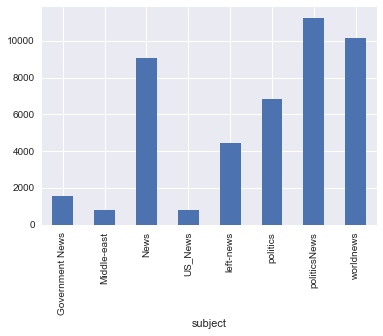

In [136]:
#to show the bar chart for fake news and real news
print(clean_newsdata.groupby(['subject'])['text'].count())
clean_newsdata.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

This graph shows that in each subject, how many times they show up. 

Then, let us see the number of news in each type, like political News or ther types.

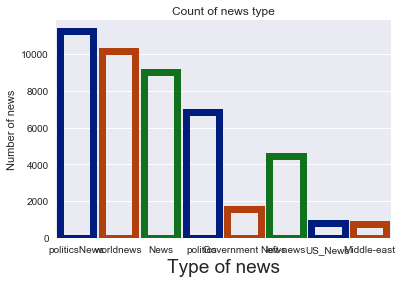

In [180]:
#Plotting the frequency plot to see what is 
ax = sns.countplot(x="subject", data=clean_newsdata,
                   facecolor=(0,0,0,0),
                   linewidth=7,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(19)


These two graphs below shows that in fake news and true news, how many outputs in each subject. 

In [183]:
#Rearranging the columns
fake_news = fake_data[['subject', 'date', 'title','target']]
true_news = real_data[['subject', 'date', 'title','target']]

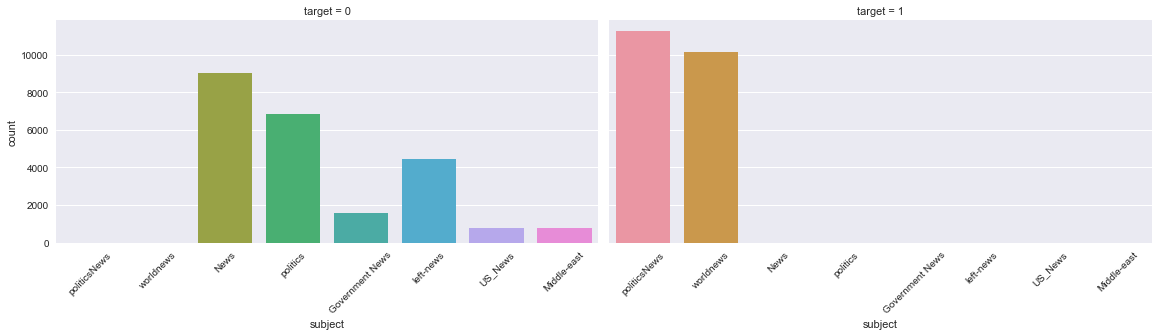

In [149]:
g = sns.catplot(x="subject", col="target",
                data=clean_newsdata, kind="count",
                height=4, aspect=3)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

This graph below shows the comparison with fake news and real news in the histogram format, so we can directly see the number od fake and real news in our dataset. 

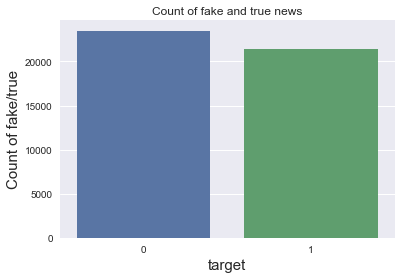

In [150]:
#show the comparison with fake news and real news in the histogram

ax=sns.countplot(x="target", data=clean_newsdata)

#Setting labels and font size
ax.set(xlabel='target', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

Now, let's see the most high frequency words in the dataset in an image! It is directly for us to grab five to ten words. 

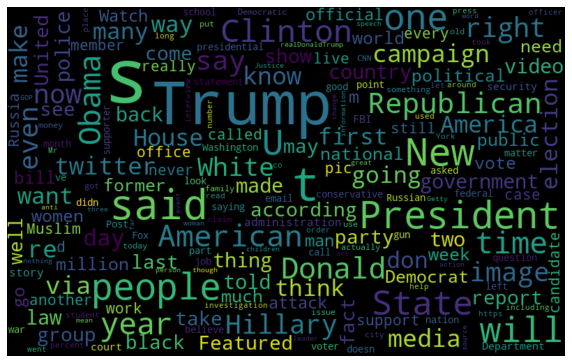

In [171]:
#to show the high frequency words in an image
from wordcloud import WordCloud
real_data = data[data["target"] == "real"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110,
 collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

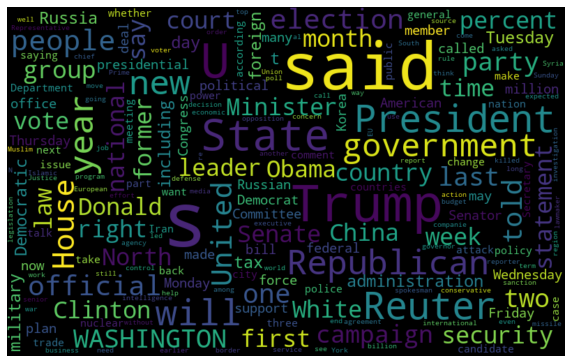

In [177]:
from wordcloud import WordCloud
fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in real_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## 5. Classification

### 5.1. CountVectorizer

In [8]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [9]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['target'], \
                                                    test_size=0.3, random_state=15)

Store the news texts from the training set and the testing set into two corpuses. We then can use the two corpuses to create the data frames for training models. Firstly, apply 'CountVectorizer' to convert the texts to a matrix of token counts. In this case, we set the maximum numer of features as 5000. Remove rare words and common words from the data by setting min_df=0.01 and max_df=0.5. Also, extract word n-grams with no more than 3 words from the texts by setting ngram_range=(1,3).

In [10]:
# corpus
corpus = []
te_corpus = []
for i in x_train:
    corpus.append(i)
for i in x_test:
    te_corpus.append(i)

cv = CountVectorizer(max_features=5000, ngram_range=(1,3), min_df = 0.01, max_df = 0.5)
x_tr_cv = cv.fit_transform(corpus).toarray()
x_te_cv = cv.transform(te_corpus).toarray()

### 5.2. TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

Secondly, try applying TF-IDF to construct another two data frames to train models. Similarly, set the maximum number of features as 5000, n-gram range as (1, 3). Also, remove rare words and common words from the data. We can compare the performance of these 3 data frames in the following parts

In [12]:
# TF
tf = TfidfVectorizer(max_features=5000, ngram_range = (1,3), min_df = 0.01, \
                     max_df = 0.5, use_idf=False)
x_tr_tf = tf.fit_transform(corpus)
x_te_tf = tf.transform(te_corpus)

# IDF
idf = TfidfVectorizer(max_features=5000, ngram_range = (1,3), min_df = 0.01, \
                      max_df = 0.5, use_idf=True)
x_tr_idf = idf.fit_transform(corpus)
x_te_idf = idf.transform(te_corpus)

Since the data used are public news data, we can use the data to train models safely.

### 5.3. Logistic regression

Logistic regression model can be used to do classification. Try using logistic regression to classify fake news from real news. Do a 3-fold cross validation for models.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [28]:
C_grid = np.logspace(-9, 6, 31)

def LR_model(x_train, x_test):
    validation_scores, test_scores = [], []
    for C in C_grid:
        logistic = LogisticRegression(C = C, solver = 'liblinear')
        va_acc = cross_val_score(logistic, x_train, y_train, cv=3)
        logistic.fit(x_train, y_train)
        y_te_pred = logistic.predict(x_test)
        te_acc = accuracy_score(y_test, y_te_pred)
        validation_scores.append(np.mean(va_acc))
        test_scores.append(te_acc)
        
    plt.plot(np.log10(C_grid), validation_scores, '-r')
    plt.plot(np.log10(C_grid), test_scores, '-b')
    plt.title('Accuracy versus log C')
    plt.xlabel('log10(C)');
    plt.ylabel('accuracy');
    plt.legend(labels = ['validation accuracy','testing accuracy'])
        
    max_te_acc = max(test_scores)
    C_max_te_acc = C_grid[test_scores.index(max_te_acc)]
    print("Best log(C) for LR: %.3f" % np.log10(C_max_te_acc))
    print("The highest testing accuracy is: %.3f" % max_te_acc)  

Best log(C) for LR: 0.000
The highest testing accuracy is: 0.999


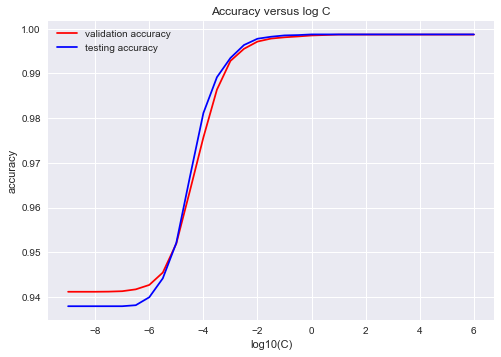

In [29]:
LR_model(x_tr_cv, x_te_cv)

Train a logistic regression model using the CountVectorizer data frame. The accuracy of the testing data set is apparently lower than the training data set when log(C) is smaller than -4. The highest testing accuracy gets to 99.9% when log(C)=0.

Best log(C) for LR: 3.000
The highest testing accuracy is: 0.999


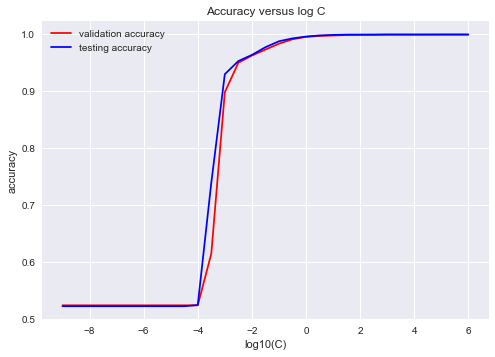

In [30]:
LR_model(x_tr_tf, x_te_tf)

Best log(C) for LR: 4.500
The highest testing accuracy is: 0.999


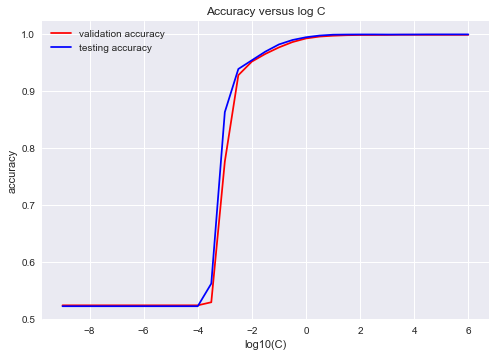

In [31]:
LR_model(x_tr_idf, x_te_idf)

As for the TF and IDF data models, the training accuracy and the testing accuracy has almost no difference. The highest accuracy is 99.9% for these two models as well.

### 5.4. SVM

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [17]:
def SVM_model(x_train, x_test):
    clf = svm.SVC(gamma=0.001)
    clf.fit(x_train, y_train)
    svm_tr_pred = clf.predict(x_train)
    svm_te_pred = clf.predict(x_test)
    tr_acc = accuracy_score(y_train, svm_tr_pred)
    te_acc = accuracy_score(y_test, svm_te_pred)
    print("The training accuracy is: %.3f" % tr_acc)  
    print("The testing accuracy is: %.3f" % te_acc)  

In [18]:
#using SVM model to seperate, and get the accuracy
SVM_model(x_tr_cv, x_te_cv)

The training accuracy is: 0.999
The testing accuracy is: 0.998


In [19]:
SVM_model(x_tr_tf, x_te_tf)

The training accuracy is: 0.956
The testing accuracy is: 0.951


In [20]:
SVM_model(x_tr_idf, x_te_idf)

The training accuracy is: 0.894
The testing accuracy is: 0.894


The SVM model has a better performance when using the CountVectorizer data and has the worst performance when using the IDF data. Also, the performance of SVM models are slightly worse than logistic regession models, although the accuracies of the three SVM models are high as well. 

## 6. Communication

Yes, we annotate by making explanations and describing the goal of each part and step by step. 
For our particular directions like we want to find the difference between fake and true news, after the analysis and decisions, we think our methods and paths are easy for us to think. We may think about other alternative paths in the future but not now. 

Here below are our conclusions. The top frequency subjects for news are politicsNews, worldnews, News, and politics. The top counts of news type are political News, worldnews, and News. The top topics under fake news are News and politics, and for real news are politicalNews and worldnews. The comparison on counts for different subjects based on the image shows more the fake news. The high frequency words for fake news and true news, we can see that Trump, President, government, are the top words containing by the dataset. 

Our future directions would be focused on Time Series Analysis for this true and fake news. 
Yes, we posted our dataset and notebooks to Github. 

## 7. Ethical Considerations

The first concern is the discrimination problems if we output some sentimental words related to age, gender, race, religion, and more, from fake news or true news dataset. Therefore, some people who belong to these groups might be affected. Another consideration is whether our output will reinforce human biases. However, these considerations will not include in the problem statement because our project want to focus on research on the data that the CSV provided for us rather than how to find and write data. However, that does not mean we ignore the biases at all. In our conclusion after our output, we will consider the biases of the dataset. Some bad-faith actor may use out models to use as Political opposition.